# Kaggle 2016 Primary Election (Democrat)


### 1. Setting up

Setting Working Directory:

In [1]:
setwd("/Users/Jimmy/Desktop/Signal Dataset/2016-us-election")

Loading the data:

In [2]:
dict = read.csv("county_facts_dictionary.csv", stringsAsFactors = FALSE)
county_facts = read.csv("county_facts.csv", stringsAsFactors = FALSE)
votes = read.csv("primary_results.csv", stringsAsFactors = FALSE)


Installing/Loading relevant libraries:

In [3]:
install.packages('dummies', repos='http://cran.us.r-project.org')
install.packages('corrplot', repos='http://cran.us.r-project.org')
install.packages('e1071', repos='http://cran.us.r-project.org')
install.packages('ranger', repos = 'http://cran.us.r-project.org')
install.packages('gbm', repos = 'http://cran.us.r-project.org')
install.packages('plotly',repos='http://cran.us.r-project.org' )
library('dummies')
library('plyr')
library('dplyr')
library('caret')
library('corrplot')
library('glmnet')
library('e1071')
library('ranger')
library('gbm')
library('ggplot2')
library('plotly')

dummies-1.5.6 provided by Decision Patterns


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5

Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:caret’:

    cluster

Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:graphics’:

    layout



Selecting rows that correspond to "Democrat" and "Hillary Clinton"

In [4]:
votes = filter(votes, party == "Democrat", candidate == "Hillary Clinton")

Joining votes and features (containing information by each county)

In [5]:
joined = merge(votes, county_facts, by = "fips")

Leaving only the target (fraction of votes supporting Clinton) and features (excluding the state information) from the "joined" data frame

In [6]:
joined = joined[c(-1:-7, -9:-10)]
joined[2:52] = scale(joined[2:52]) #Scaling features 


# Regressions

*NOTE*: In all of the following regressions, I am using features ***without*** state information. It is possible to get significantly better predictive power with such information. However, to find out which of the ~50 features are important indicator of support for Clinton, I will exclude the state information. 

##### 1. Elastic Net

Preparing to run elastic net regression using caret pacakge (10-fold cross validation)

In [7]:
caret_reg = function(x, y, method, grid, ...){
  set.seed(1)
  control = trainControl(method="repeatedcv", repeats=1, number=10, verboseIter=TRUE)
  train(x=x, y=y, method=method, tuneGrid=grid, 
        trControl=control, metric="RMSE",
        ...)
}

vote_features = select(joined, PST045214:POP060210)
vote_target = select(joined, fraction_votes)
vote_target = vote_target$fraction_votes # caret doesn't accept data frame as its target so I'm converting it into a vector

grid_glmnet = expand.grid(alpha = 0.95959, lambda = 2.043006e-05) # Selecting values of alpha and lamba to search over

Note: in the above cell, I am passing in the "ideal" values of alpha and lambda obtained from running elastic net regression over many different values of alpha and lambda. I decided to do so since searching over many hyperparameters may take significant amount of computational time. This will be so for the following models that I will be using.

Running elastic net regression:

In [10]:
fit_glmnet = caret_reg(scale(vote_features), vote_target, "glmnet", grid_glmnet)

+ Fold01.Rep1: alpha=0.9596, lambda=2.043e-05 
- Fold01.Rep1: alpha=0.9596, lambda=2.043e-05 
+ Fold02.Rep1: alpha=0.9596, lambda=2.043e-05 
- Fold02.Rep1: alpha=0.9596, lambda=2.043e-05 
+ Fold03.Rep1: alpha=0.9596, lambda=2.043e-05 
- Fold03.Rep1: alpha=0.9596, lambda=2.043e-05 
+ Fold04.Rep1: alpha=0.9596, lambda=2.043e-05 
- Fold04.Rep1: alpha=0.9596, lambda=2.043e-05 
+ Fold05.Rep1: alpha=0.9596, lambda=2.043e-05 
- Fold05.Rep1: alpha=0.9596, lambda=2.043e-05 
+ Fold06.Rep1: alpha=0.9596, lambda=2.043e-05 
- Fold06.Rep1: alpha=0.9596, lambda=2.043e-05 
+ Fold07.Rep1: alpha=0.9596, lambda=2.043e-05 
- Fold07.Rep1: alpha=0.9596, lambda=2.043e-05 
+ Fold08.Rep1: alpha=0.9596, lambda=2.043e-05 
- Fold08.Rep1: alpha=0.9596, lambda=2.043e-05 
+ Fold09.Rep1: alpha=0.9596, lambda=2.043e-05 
- Fold09.Rep1: alpha=0.9596, lambda=2.043e-05 
+ Fold10.Rep1: alpha=0.9596, lambda=2.043e-05 
- Fold10.Rep1: alpha=0.9596, lambda=2.043e-05 
Aggregating results
Fitting final model on full training set

Examining the best set of hyperparameters (alpha and lambda) of the model, minimum RMSE, and maximum R-Squared value

In [11]:
best_tune = fit_glmnet$bestTune
best_tune # alpha = 0.95959 and lambda = ~0

min_rmse = min(fit_glmnet$results$RMSE)
min_rmse #0.099615

glmnet_max.Rsquared = max(na.omit(fit_glmnet$results$Rsquared))
glmnet_max.Rsquared #0.61446



,alpha,lambda
1,9.595900e-01,2.043006e-05


[1] 0.09961546

[1] 0.6144648

From the above result, we know that the current linear model can explain about 60% of the variance (0.61446 * 100) in the target variable and that it can, on average, predict fraction vote for Clinton with about 10% (0.099615 * 100) accuracy, given information about each county. 

Now, let's see how a non-linear model performs on the dataset.

##### 2. Random Forest

In [12]:
grid_rf = expand.grid(mtry=25) # here again, I initally searched over many values of mtry and chose mtry = 25.
fit_rf = caret_reg(vote_features, vote_target, "ranger", grid_rf, importance="impurity")
min(fit_rf$results$RMSE) # 0.09032188
max(fit_rf$results$Rsquared) #0.684715
fit_rf$bestTune # mtry= 25

+ Fold01.Rep1: mtry=25 
- Fold01.Rep1: mtry=25 
+ Fold02.Rep1: mtry=25 
- Fold02.Rep1: mtry=25 
+ Fold03.Rep1: mtry=25 
- Fold03.Rep1: mtry=25 
+ Fold04.Rep1: mtry=25 
- Fold04.Rep1: mtry=25 
+ Fold05.Rep1: mtry=25 
- Fold05.Rep1: mtry=25 
+ Fold06.Rep1: mtry=25 
- Fold06.Rep1: mtry=25 
+ Fold07.Rep1: mtry=25 
- Fold07.Rep1: mtry=25 
+ Fold08.Rep1: mtry=25 
- Fold08.Rep1: mtry=25 
+ Fold09.Rep1: mtry=25 
- Fold09.Rep1: mtry=25 
+ Fold10.Rep1: mtry=25 
- Fold10.Rep1: mtry=25 
Aggregating results
Fitting final model on full training set


[1] 0.09032189

[1] 0.6847152

,mtry
1,25


From the result, we can see that the random forest model does perform better in that it yields lower RMSE and higher R-Squared values(RMSE:0.09032188 and R-Squared:0.684715) compared to those of the elastic net regression model (RMSE:0.09961546 and R-Squared: 0.6144648). Knowing that the non-linear model performs better than the linear model, we will proceed to run a gradient boosted trees model since a boosted tree model is known to generally perform better than a random forest model.

##### 3. Gradient Boosted Trees

In [8]:
grid_gbm = expand.grid(n.trees=1500, shrinkage= 0.01,
                       interaction.depth=40, n.minobsinnode=1)
# similar to the case in the random forest model, I chose hyperparameters that performed best after having run the model with wide range of hyperparameters.
fit_gbm = caret_reg(as.matrix(vote_features), vote_target, "gbm", grid_gbm)
min(fit_gbm$results$RMSE) # 0.08711292
max(fit_gbm$results$Rsquared) # 0.7038636
fit_gbm$bestTune #n.trees = 1500, interaction.depth = 40, shrinkage = 0.01, n.minobsinnode = 1


+ Fold01.Rep1: n.trees=1500, shrinkage=0.01, interaction.depth=40, n.minobsinnode=1 
Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.0249             nan     0.0100    0.0003
     2        0.0245             nan     0.0100    0.0003
     3        0.0242             nan     0.0100    0.0003
     4        0.0239             nan     0.0100    0.0003
     5        0.0236             nan     0.0100    0.0003
     6        0.0232             nan     0.0100    0.0003
     7        0.0229             nan     0.0100    0.0003
     8        0.0227             nan     0.0100    0.0002
     9        0.0224             nan     0.0100    0.0003
    10        0.0221             nan     0.0100    0.0002
    20        0.0194             nan     0.0100    0.0002
    40        0.0154             nan     0.0100    0.0001
    60        0.0124             nan     0.0100    0.0001
    80        0.0103             nan     0.0100    0.0001
   100        0.0087             nan     0.01

[1] 0.08716088

[1] 0.7034872

,n.trees,interaction.depth,shrinkage,n.minobsinnode
1,1500.00,40.00,0.01,1.00


Compared to the elastic net regression model (RMSE: 0.099615, R-Squared: 0.61446), gradient boosted trees performed better (RMSE: 0.08711292, R-Squared: 0.7038636). 



Having seen that the gradient boosted trees model outperforms the previous two models, I will move onto interpreting what variables from the features are important for vote prediction.

# Interpretation

##### 1. Examining variable importance

Top 5 largest relative influence/importance of variables in the gradient boosted trees model:

,var,rel.inf
RHI225214,RHI225214,37.4919960517805
RHI625214,RHI625214,4.50866381514886
RHI725214,RHI725214,3.25633770595578
HSG495213,HSG495213,2.8247025486858
SEX255214,SEX255214,2.31370819540162


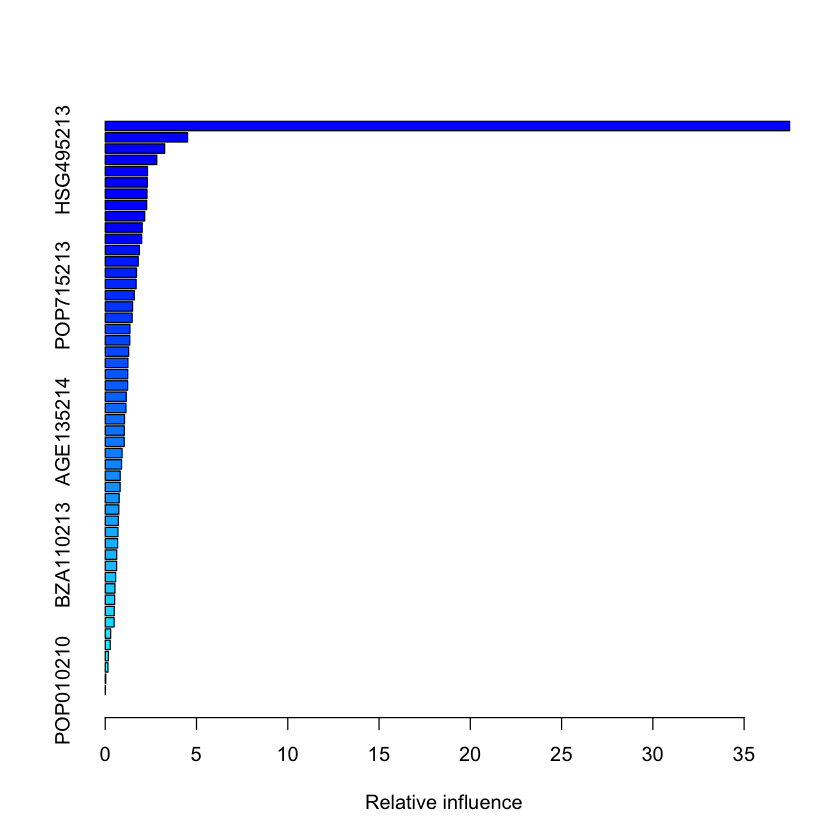

In [10]:
head(summary(fit_gbm), 5) # calling first 10 largest relative influence of variables

Referring to dict(county_facts_dictionary.csv), we can see that the first 5 most important variables in predicting fraction of vote for Clinton are as follows:

In [15]:
dict[c(10, 14, 15, 27, 8), ]

,column_name,description
10,RHI225214,"Black or African American alone, percent, 2014"
14,RHI625214,"Two or More Races, percent, 2014"
15,RHI725214,"Hispanic or Latino, percent, 2014"
27,HSG495213,"Median value of owner-occupied housing units, 2009-2013"
8,SEX255214,"Female persons, percent, 2014"


Based on the table, we can conclude that the 5 most important features are Black or African American population percentage , mixed race population percentage, Hispanic or Lationo population percentage, median housing price, and female percentage in a county. It is noteworthy to mention that Black or African American population percentage has much higher relative influence (close to factor of 10) compared to other four variables.

##### 2. Examining correlation between the target variable and the features variable

Having looked at which variables are most important, let's see how these variables (along with others) correlate with the fraction of vote supporting Clinton. First, let's start the five variables we just looked at:

In [21]:
correlation_vote = cor(vote_features, vote_target)
correlation_vote = round(correlation_vote, 3)
correlation_dict = cbind(dict, correlation_vote)
correlation_dict[c(10, 14, 15, 27, 8), ]

,column_name,description,correlation_vote
RHI225214,RHI225214,"Black or African American alone, percent, 2014",0.693
RHI625214,RHI625214,"Two or More Races, percent, 2014",-0.233
RHI725214,RHI725214,"Hispanic or Latino, percent, 2014",0.075
HSG495213,HSG495213,"Median value of owner-occupied housing units, 2009-2013",-0.15
SEX255214,SEX255214,"Female persons, percent, 2014",0.13


Here, we observe a strong positive correlation between African American population percentage and fraction of vote for Clinton. On the contray, we observe a weak negative correlation between mixed race population and the fraction of vote and between median housing value and the fraction of vote. It may also be worth noting that having a higher percentage of females in a county has a weak postive correlation with the vote. 

Plotting the largest correlation (African American population) from the table above:

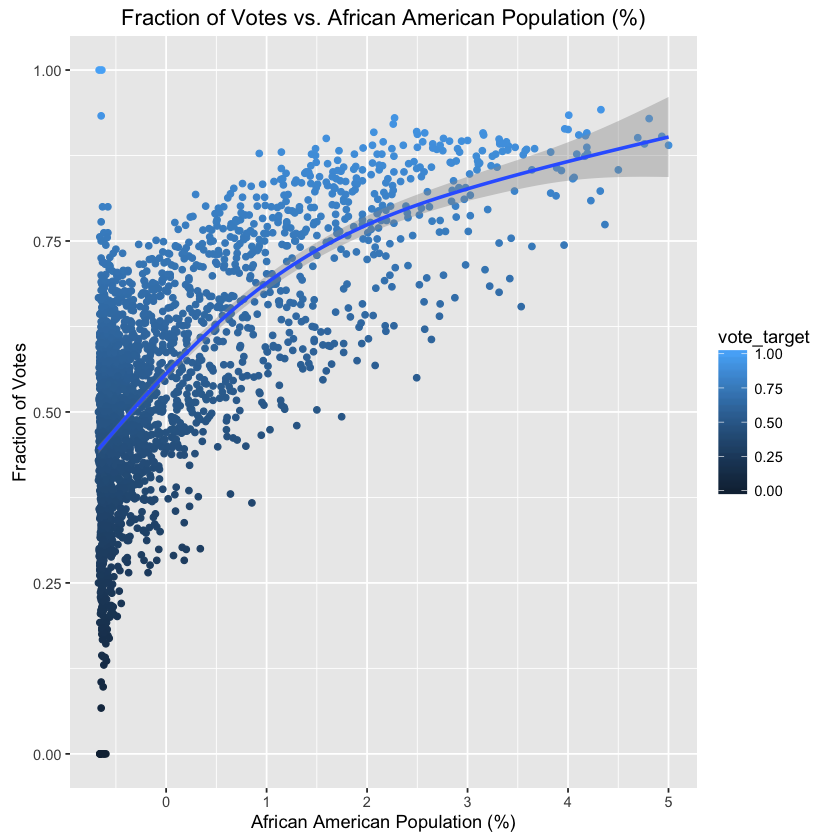

In [17]:
qplot(y = vote_target, x = vote_features$RHI225214, color = vote_target) + geom_smooth() + xlab("African American Population (%)") +
  ylab("Fraction of Votes") + ggtitle("Fraction of Votes vs. African American Population (%)")

As expected, we observe that the fraction of votes increase as the percentage of African American population increases.

Now, let's take a look at some of the variables with largest correlation coefficients:

In [18]:
large_correlation = filter(correlation_dict, abs(correlation_vote) >= 0.3) #showing only the rows with correlation >= 0.3
large_correlation

,column_name,description,correlation_vote
1,RHI125214,"White alone, percent, 2014",-0.567
2,RHI225214,"Black or African American alone, percent, 2014",0.693
3,RHI825214,"White alone, not Hispanic or Latino, percent, 2014",-0.509
4,EDU635213,"High school graduate or higher, percent of persons age 25+, 2009-2013",-0.401
5,PVY020213,"Persons below poverty level, percent, 2009-2013",0.303
6,SBO315207,"Black-owned firms, percent, 2007",0.421


In the table above, we see that support for Hillary is negatively correlated with percentage of white population and high school graduate or higher. On the other hand, support for Hillary is positively correlated with African American population (as we saw earlier) and poverty level. 

From the correlation coefficient table above, I'm curious about whether the positive correlation between poverty and support for Clinton is due entirely to African American population as African Americans tend to have lower income. Similarly, I wonder if the negative correlation between Clinton and high education is entirely due to African American population having lower education. To find out, I will first look at correlations among these features. 

In [14]:
features2 = vote_features[c("RHI225214", "EDU635213", "PVY020213")]
bound = cbind(vote_target, features2)
colnames(bound) = c("hillary", "black", "highSchoolPlus", "poverty")
round(cor(bound), 2)

,hillary,black,highSchoolPlus,poverty
hillary,1.00,0.69,-0.40,0.30
black,0.69,1.00,-0.34,0.45
highSchoolPlus,-0.40,-0.34,1.00,-0.65
poverty,0.30,0.45,-0.65,1.00


We can see from the table above that "black" is indeed positively correlated with "poverty" and negatively correlated with "highSchoolPlus." What would happen if we control for African American population? Would we still find positive correlation between poverty and support for Clinton and negtavie correlation between high education and support for clinton? To find out, I will run linear regression with these features and examine coefficients.

In [17]:
summary(lm(bound[-3])) # using just "black" and "poverty" as predictors
summary(lm(bound[-4])) # using just "black" and "highSchoolPlus" as predictors


Call:
lm(formula = bound[-3])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46939 -0.07149  0.00234  0.07897  0.53638 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.536009   0.002180  245.83   <2e-16 ***
black        0.111338   0.002437   45.68   <2e-16 ***
poverty     -0.001244   0.002437   -0.51     0.61    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1153 on 2795 degrees of freedom
Multiple R-squared:  0.4801,	Adjusted R-squared:  0.4797 
F-statistic:  1290 on 2 and 2795 DF,  p-value: < 2.2e-16



Call:
lm(formula = bound[-4])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53367 -0.06592  0.00725  0.07738  0.57659 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.536009   0.002114  253.55   <2e-16 ***
black           0.100608   0.002247   44.77   <2e-16 ***
highSchoolPlus -0.030038   0.002247  -13.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1118 on 2795 degrees of freedom
Multiple R-squared:  0.5113,	Adjusted R-squared:  0.5109 
F-statistic:  1462 on 2 and 2795 DF,  p-value: < 2.2e-16


After examining each coefficient, it seems that after controlling for African American Population, poverty level does not seem to affect support for Clinton (coefficient for poverty did not reach statistical significance). From this, it seems reasonable to conclude that positive correlation between poverty and support for Clinton may be due just to African American population. On the contrary, we still see negative correlation between high education and support for Clinton after controlling for African American population.

# Conclusion

- After trying out three different models (elastic net regression, random forest, gradient boosted trees), I found that *gradient boosted trees* perform the best in predicting support for Clinton with RMSE of 0.08711292 and R-squared of 0.7038636. 
- It seems that *racial information* about each county is the most important predictor, especially that of *African American population*. 
- There's also a small negative correlation between high education (high school or above) and support for Clinton.